<a href="https://colab.research.google.com/github/jamagiwa/Kaggle/blob/Explore_und_practice/GBM_scRNAseq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#GBM scRNAseqデータを用いてEDAの練習する

What: scRNAseqデータを用いて解析の手法を学ぶ

---

Why: 遺伝子発現、epigenome、proteomeデータを自由に扱えるようになりたいため

---

Result


##データの読み込み、データフレームを作成

使うライブラリ

In [18]:
#Colaboにanndataをダウンロード
!pip install anndata scanpy
!pip install leidenalg
!pip install igraph
!pip install gseapy

In [79]:
import kagglehub
import scipy.io
import pandas as pd
import anndata as ad
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import gseapy as gp
import matplotlib.patches as mpatches
import os

In [20]:
#データのダウンロード
!pip install kagglehub


# Download latest version
path = kagglehub.dataset_download("reminho/human-glioblastoma-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/human-glioblastoma-dataset


In [21]:
#ファイル名の確認
import os
print(os.listdir(path))

['barcodes.tsv', 'matrix.mtx', 'genes.tsv']


barcodes.tsv...各細胞のID, matrix.mtx...実際の遺伝子発現data(ほとんどのgeneが0なので特殊な形式で効率よく保存している。), genes.tsv...遺伝子名のリスト

3つのファイルを読み込む

In [22]:
#ファイルパスを設定
path = "/kaggle/input/human-glioblastoma-dataset"
barcodes_file = f"{path}/barcodes.tsv"
gene_file = f"{path}/genes.tsv"
matrix_file = f"{path}/matrix.mtx"

print(matrix_file)

/kaggle/input/human-glioblastoma-dataset/matrix.mtx


##QC, ノイズ除去

In [23]:
# ----------------- 遺伝子リストを正しく読み込む -----------------
# sep='\t'でタブ区切りを指定し、2列目（遺伝子名）をインデックスとして読み込む
genes_df = pd.read_csv(gene_file, header=None, sep='\t')

# ----------------- AnnDataオブジェクトを作成 -----------------
adata = ad.AnnData(
    X=scipy.io.mmread(matrix_file).T.tocsr(),
    obs=pd.read_csv(barcodes_file, header=None, sep='\t', names=['cell_barcode']),
    var=pd.DataFrame(index=genes_df.iloc[:, 1].values)
)

# ----------------- 遺伝子情報（ID、Gene Expressionなど）をadata.varに保存 -----------------
adata.var['gene_id'] = genes_df.iloc[:, 0].values
adata.var['feature_type'] = genes_df.iloc[:, 2].values

# ----------------- 確認 -----------------
print(adata.var)

                gene_id     feature_type
GNB1    ENSG00000078369  Gene Expression
TP73    ENSG00000078900  Gene Expression
PARK7   ENSG00000116288  Gene Expression
TARDBP  ENSG00000120948  Gene Expression
MTOR    ENSG00000198793  Gene Expression
...                 ...              ...
MECP2   ENSG00000169057  Gene Expression
FLNA    ENSG00000196924  Gene Expression
TAZ     ENSG00000102125  Gene Expression
RAB39B  ENSG00000155961  Gene Expression
SRY     ENSG00000184895  Gene Expression

[1186 rows x 2 columns]


/usr/lib/python3.12/functools.py:912: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [24]:
#anndataのコピーを作成、元データの保護
adata_fil = adata.copy()

#遺伝子のフィルタリング
#少なくとも3つの細胞で発現している遺伝子を残す
#pp...pre-processing
sc.pp.filter_genes(adata_fil, min_cells=3)

#少なくとも200の細胞で発現している遺伝子を残す
sc.pp.filter_cells(adata_fil, min_genes=200)

print(f"元の細胞数{adata.n_obs}, 遺伝子数{adata.n_vars}")
print(f"フィルタリング後の細胞数{adata_fil.n_obs}, 遺伝子数{adata_fil.n_vars}")

元の細胞数5697, 遺伝子数1186
フィルタリング後の細胞数4433, 遺伝子数1140


/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


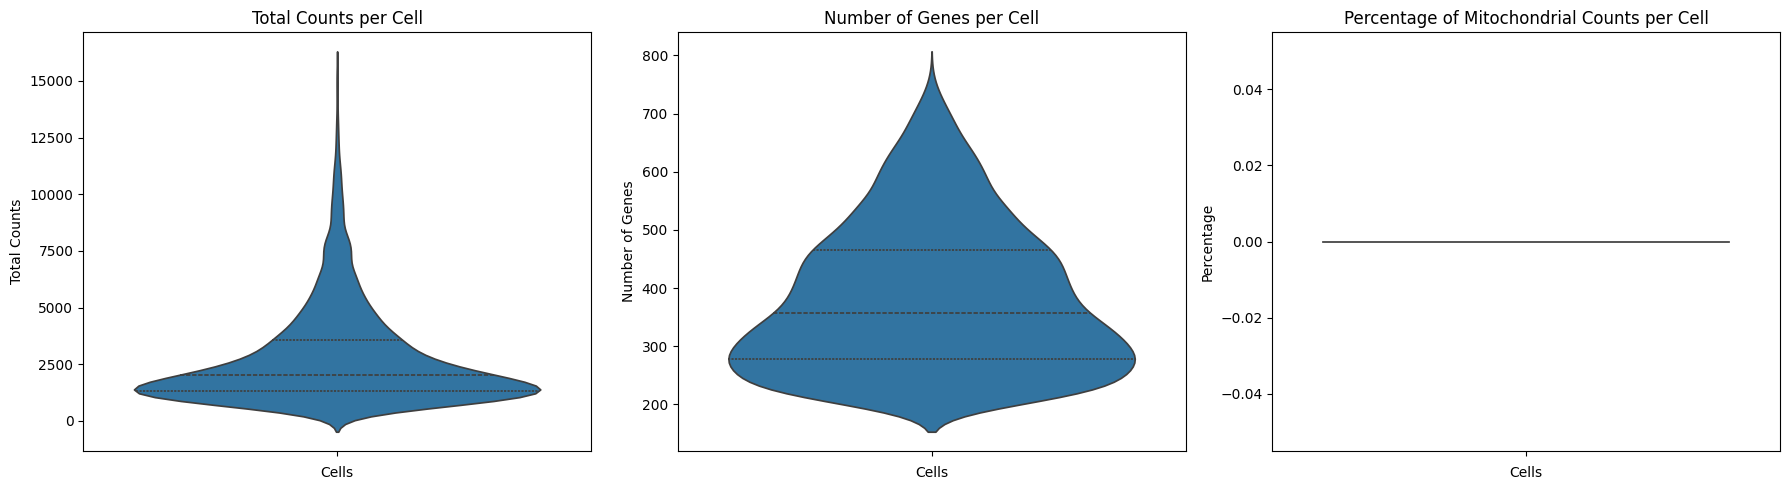

In [25]:
#ミトコンドリア遺伝子を識別する
#"MT"で始まる遺伝子を探す
adata_fil.var['MT'] = adata_fil.var['gene_id'].str.startswith("MT-")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# QCメトリクスを計算
sc.pp.calculate_qc_metrics(adata_fil, qc_vars=['MT'], percent_top=None, log1p=False, inplace=True)

# バイオリンプロット1: 総読取数
sns.violinplot(y='total_counts', data=adata_fil.obs, ax=axes[0], inner='quartile')
axes[0].set_title('Total Counts per Cell')
axes[0].set_xlabel('Cells')
axes[0].set_ylabel('Total Counts')

# バイオリンプロット2: 発現遺伝子数
sns.violinplot(y='n_genes_by_counts', data=adata_fil.obs, ax=axes[1], inner='quartile')
axes[1].set_title('Number of Genes per Cell')
axes[1].set_xlabel('Cells')
axes[1].set_ylabel('Number of Genes')

# バイオリンプロット3: ミトコンドリア遺伝子の割合
sns.violinplot(y='pct_counts_MT', data=adata_fil.obs, ax=axes[2], inner='quartile')
axes[2].set_title('Percentage of Mitochondrial Counts per Cell')
axes[2].set_xlabel('Cells')
axes[2].set_ylabel('Percentage')

plt.tight_layout()
plt.show()

MTが０なのはなぜかと思ったらすでに取り除いてくれている

In [26]:
True_count = sum(adata_fil.var["MT"])
print(f"Trueの数{True_count}")

False_count = sum(~adata_fil.var["MT"])
print(f"Falesの数{False_count}")


Trueの数0
Falesの数1140


#Normalization, 次元削減

Lognormalizeで行う。一般的な方法らしい。細胞数で割った後に対数変換する

---

対数変換...正規分布に近似、外れ値の影響の軽減、線形性の確保、スケールの収縮

In [27]:
#正規化
#遺伝子発現データの合計が10000になるようにスケーリング、対数変換を行う。
#ノーマライズの値は多くの文献で行われる10000でおこなう。
sc.pp.normalize_total(adata_fil, target_sum=1e4)

#対数変換を行う(log(x+1))
sc.pp.log1p(adata_fil)

次元削減を行う

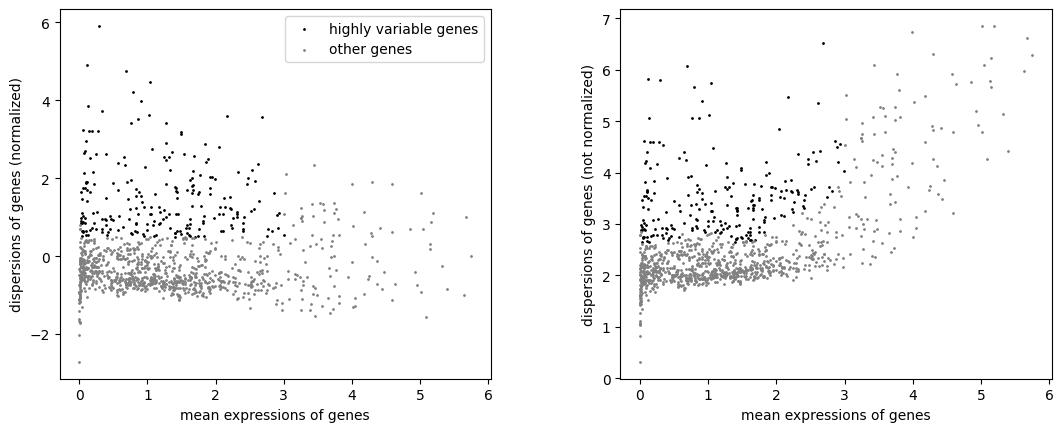

In [28]:
#σが大きい細胞を特定する
#min_mian...平均発現量が0.0125を排除、ノイズの除去, max_mean...発現量が平均３以上を排除, min_disp 分散の最小値
sc.pp.highly_variable_genes(adata_fil, min_mean=0.0125, max_mean=3.0, min_disp=0.5)
sc.pl.highly_variable_genes(adata_fil)

発現量が大きい遺伝子は、サンプリングノイズが入り分散が大きくなる傾向がある。
発現量は少ないが、分散が高い遺伝子→少数の細胞で発現している（生物学的意味のある細胞）を特定するために行う。

##次元削減

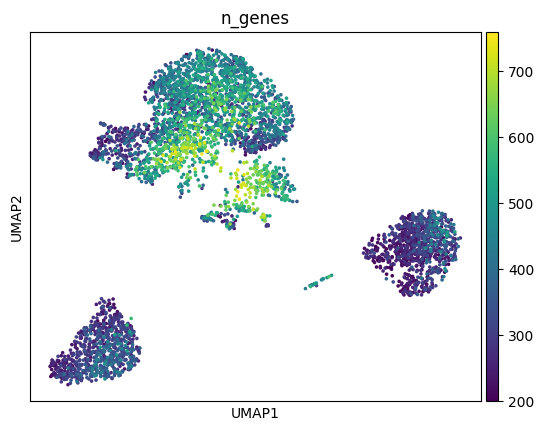

In [29]:
#PCAを行う
#50次元に落とし込む
sc.pp.pca(adata_fil, n_comps=50)

# 近傍グラフを計算
#dim(PCA)だとまだ次元数が大きい。高次元の距離を2~3次元に落とし込むアルゴリズム
#近さの計算を行う。
sc.pp.neighbors(adata_fil, n_neighbors=10, n_pcs=40)

#UMAP
sc.tl.umap(adata_fil)
sc.pl.umap(adata_fil, color = "n_genes")

200~700...対数変換後の遺伝子発現量

##細胞の同定、マーカー探索

In [30]:
print(adata_fil.var_names)

Index(['GNB1', 'TP73', 'PARK7', 'TARDBP', 'MTOR', 'MTHFR', 'CLCN6', 'NPPB',
       'MFN2', 'TNFRSF1B',
       ...
       'XIAP', 'SLC9A6', 'FMR1', 'ATP2B3', 'PLXNB3', 'L1CAM', 'MECP2', 'FLNA',
       'TAZ', 'RAB39B'],
      dtype='object', length=1140)


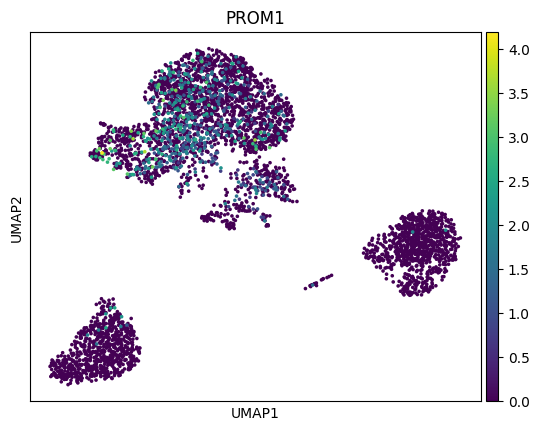

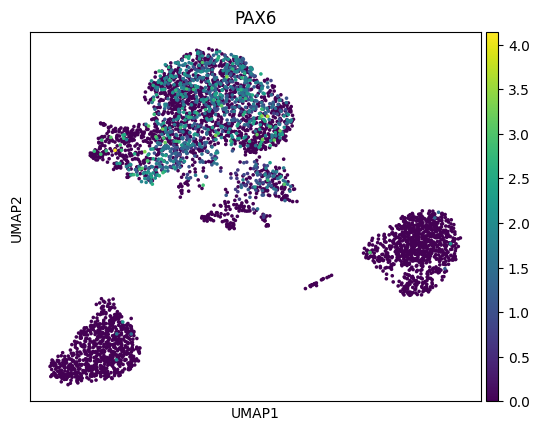

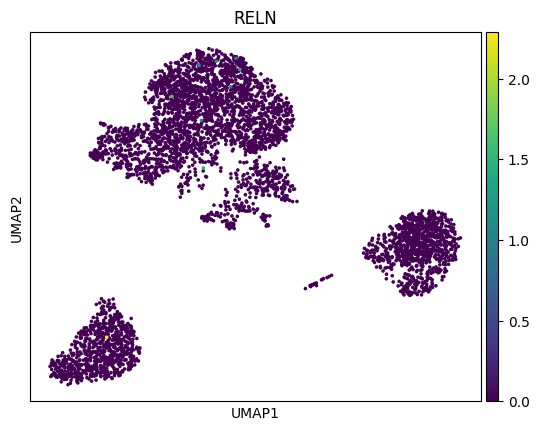

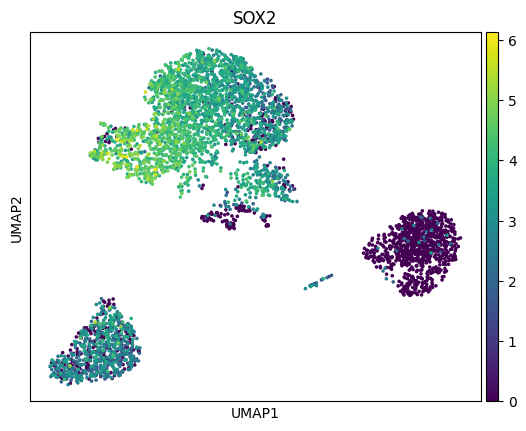

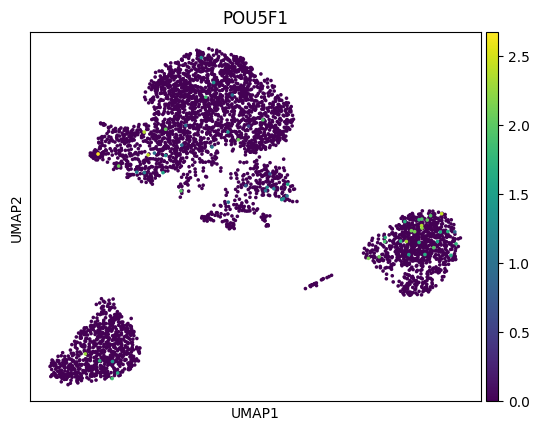

In [31]:
sc.pl.umap(adata_fil, color = "PROM1")
sc.pl.umap(adata_fil, color = "PAX6")#神経幹細胞の自己複製を維持
sc.pl.umap(adata_fil, color = "RELN")#移動中の神経細胞の停止をさえる
sc.pl.umap(adata_fil, color = "SOX2")
sc.pl.umap(adata_fil, color = "POU5F1")#OCT4

クラスタリングしてみる

/tmp/ipython-input-1612787067.py:7: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_fil, resolution=0.5)


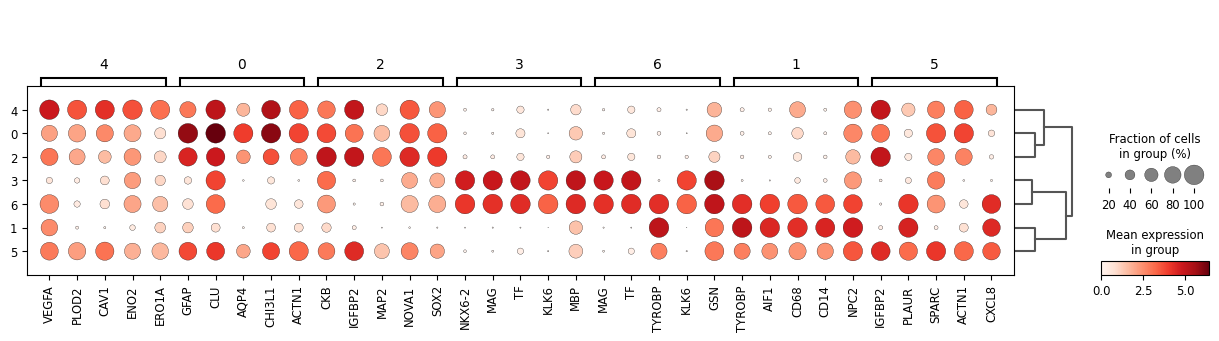

In [32]:
#Leidenクラスタリングを行う、自動的に類似細胞をグループ化してくれる
#グループ名は0, 1, 2とラベル付けされる

#遺伝子名の重複を解消する
adata_fil.var_names_make_unique()

sc.tl.leiden(adata_fil, resolution=0.5)

#マーカー遺伝子の特定
sc.tl.rank_genes_groups(adata_fil,
                        'leiden',
                        method = 't-test')

#結果をプロット
sc.pl.rank_genes_groups_dotplot(adata_fil, n_genes=5)

各クラスターのトップ５のマーカー遺伝子を表示

---
ドットの大きさ...クラスター内で発言している細胞の割合, 色...遺伝子発現レベル(正規化後の対数発現量)


よくわからないマーカーが多いので、GO解析とKEGGパスウェイ解析をする

---

G0(Gene Ontology)...遺伝子リストの中に含まれる、特定の機能(GO term)が全体に対してどれくらいあるか
KEGG...遺伝子、タンパク質、化合物の相互作用を可視化する


In [35]:
#各クラスターのマーカー遺伝子リストを取得する
# 'rank_genes_groups' の結果は adata_fil.uns['rank_genes_groups'] に保存されているらしい
results = adata_fil.uns['rank_genes_groups']
groups = results['names'].dtype.names

#各グループに対して解析を実行する
for group in groups:
 # 上位マーカー遺伝子リストを取得する
    gene_list = results['names'][group][:100].tolist()

    # 出力ディレクトリを作成
    output_dir_go = f'go_enrichment_{group}'
    output_dir_kegg = f'kegg_enrichment_{group}'
    os.makedirs(output_dir_go, exist_ok=True)
    os.makedirs(output_dir_kegg, exist_ok=True)

    # GO（Gene Ontology）解析
    go_enrichment = gp.enrichr(gene_list=gene_list,
                                gene_sets=['GO_Biological_Process_2021'],
                                organism='Human', # 生物種に応じて変更
                                outdir=output_dir_go,
                                no_plot=True) # プロットを生成しない

    # 結果をCSVファイルに保存
    if go_enrichment.results is not None and not go_enrichment.results.empty:
        go_enrichment.results.to_csv(f"{output_dir_go}/{group}_go_results.csv", index=False)
        print(f"GO解析結果（{group}）:")
        print(go_enrichment.results.head())
    else:
        print(f"GO解析結果（{group}）: 結果が見つかりませんでした。")


    # KEGGパスウェイ解析
    kegg_enrichment = gp.enrichr(gene_list=gene_list,
                                 gene_sets=['KEGG_2021_Human'],
                                 organism='Human', # 生物種に応じて変更
                                 outdir=output_dir_kegg,
                                 no_plot=True) # プロットを生成しない

    # 結果をCSVファイルに保存
    if kegg_enrichment.results is not None and not kegg_enrichment.results.empty:
        kegg_enrichment.results.to_csv(f"{output_dir_kegg}/{group}_kegg_results.csv", index=False)
        print(f"KEGGパスウェイ解析結果（{group}）:")
        print(kegg_enrichment.results.head())
    else:
        print(f"KEGGパスウェイ解析結果（{group}）: 結果が見つかりませんでした。")

print(f"KEGGパスウェイ解析結果（{group}）:")
print(kegg_enrichment.results.head())

GO解析結果（0）:
                     Gene_set  \
0  GO_Biological_Process_2021   
1  GO_Biological_Process_2021   
2  GO_Biological_Process_2021   
3  GO_Biological_Process_2021   
4  GO_Biological_Process_2021   

                                                Term Overlap       P-value  \
0  positive regulation of intracellular signal tr...  21/546  2.712639e-13   
1   regulation of ERK1 and ERK2 cascade (GO:0070372)  14/238  1.389280e-11   
2   positive regulation of MAPK cascade (GO:0043410)  14/274  9.089049e-11   
3  positive regulation of protein phosphorylation...  15/371  4.846441e-10   
4  regulation of protein kinase B signaling (GO:0...  12/207  5.191536e-10   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0      5.018382e-10            0                     0    9.810127   
1      1.285084e-08            0                     0   14.299419   
2      5.604913e-08            0                     0   12.296959   
3      1.920868e-07            0         

上記の結果をUMAPに入れる

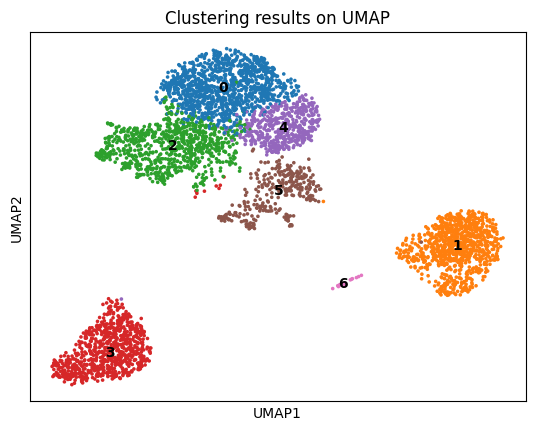

In [46]:
#leidenクラスタリング上と同じ位相グラフを利用
#各細胞の二次元上の配置を計算
sc.tl.umap(adata_fil)

#UMAPを描画


# legend_loc='on data' にすると、凡例の代わりに各クラスターのかたまりに直接番号が表示され、見やすくなる。
sc.pl.umap(
    adata_fil,
    color = 'leiden',
    legend_loc = 'on data',
    frameon = True, #プロットの枠線をなくす
    title = 'Clustering results on UMAP'
)



#グラフをまとめてみやすくする

       'CDCA7', 'DTL', 'PRIM1', 'UHRF1', 'MLF1IP', 'HELLS', 'RFC2', 'RPA2',
       'NASP', 'RAD51AP1', 'GMNN', 'WDR76', 'SLBP', 'CCNE2', 'UBR7', 'POLD3',
       'MSH2', 'ATAD2', 'RAD51', 'RRM2', 'CDC45', 'EXO1', 'TIPIN', 'DSCC1',
       'BLM', 'CASP8AP2', 'USP1', 'CLSPN', 'POLA1', 'CHAF1B', 'BRIP1', 'E2F8'],
      dtype='object')
       'CKS1B', 'TMPO', 'CENPF', 'TACC3', 'FAM64A', 'SMC4', 'CCNB2', 'CKAP2L',
       'CKAP2', 'AURKB', 'BUB1', 'KIF11', 'ANP32E', 'TUBB4B', 'GTSE1',
       'KIF20B', 'HJURP', 'CDCA3', 'CDC25C', 'KIF2C', 'RANGAP1', 'NCAPD2',
       'DLGAP5', 'CDCA2', 'CDCA8', 'ECT2', 'KIF23', 'HMMR', 'AURKA', 'PSRC1',
       'ANLN', 'LBR', 'CKAP5', 'CENPE', 'CTCF', 'NEK2', 'G2E3', 'GAS2L3',
       'CBX5', 'CENPA'],
      dtype='object')


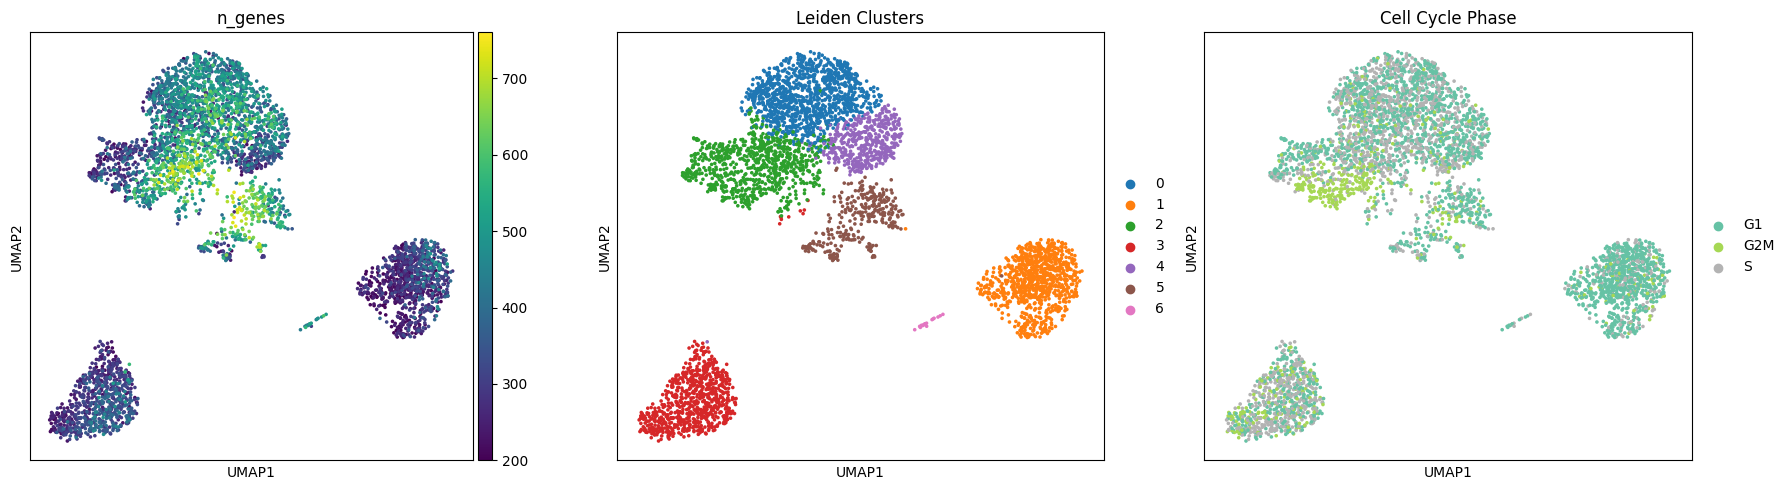

In [77]:
##細胞のphase分けができるらしいコピペしてみる
# --- 1. 細胞周期関連遺伝子リストの準備 ---
# 一般的によく使われる遺伝子リスト (Tirosh et al., 2016)
s_genes = ['MCM5', 'PCNA', 'TYMS', 'FEN1', 'MCM2', 'MCM4', 'RRM1', 'UNG', 'GINS2', 'MCM6', 'CDCA7', 'DTL', 'PRIM1', 'UHRF1', 'MLF1IP', 'HELLS', 'RFC2', 'RPA2', 'NASP', 'RAD51AP1', 'GMNN', 'WDR76', 'SLBP', 'CCNE2', 'UBR7', 'POLD3', 'MSH2', 'ATAD2', 'RAD51', 'RRM2', 'CDC45', 'CDC6', 'EXO1', 'TIPIN', 'DSCC1', 'BLM', 'CASP8AP2', 'USP1', 'CLSPN', 'POLA1', 'CHAF1B', 'BRIP1', 'E2F8']
g2m_genes = ['HMGB2', 'CDK1', 'HN1', 'CDC20', 'TOP2A', 'NDC80', 'CKS2', 'NUF2', 'CKS1B', 'MKI67', 'TMPO', 'CENPF', 'TACC3', 'FAM64A', 'SMC4', 'CCNB2', 'CKAP2L', 'CKAP2', 'AURKB', 'BUB1', 'KIF11', 'ANP32E', 'TUBB4B', 'GTSE1', 'KIF20B', 'HJURP', 'CDCA3', 'HN1', 'CDC25C', 'KIF2C', 'RANGAP1', 'NCAPD2', 'DLGAP5', 'CDCA2', 'CDCA8', 'ECT2', 'KIF23', 'HMMR', 'AURKA', 'PSRC1', 'ANLN', 'LBR', 'CKAP5', 'CENPE', 'CTCF', 'NEK2', 'G2E3', 'GAS2L3', 'CBX5', 'CENPA']

# --- 2. 細胞周期スコアリングの実行 ---
# この処理により、.obsに 'S_score', 'G2M_score', 'phase' の3つの列が追加されます
sc.tl.score_genes_cell_cycle(adata_fil, s_genes=s_genes, g2m_genes=g2m_genes)

# --- 3. プロットの実行 ---
# fig, axes に変数名を統一します
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

sc.pl.umap(adata_fil, color = "n_genes", title = 'n_genes', ax = axes[0], show = False )


sc.pl.umap(adata_fil, color='leiden', title='Leiden Clusters', ax=axes[1], show=False)


# score_genes_cell_cycle を実行したので、'phase'で色分けできます
sc.pl.umap(adata_fil, color='phase', title='Cell Cycle Phase', ax=axes[2], show=False, palette = 'Set2')


plt.tight_layout()
plt.show()

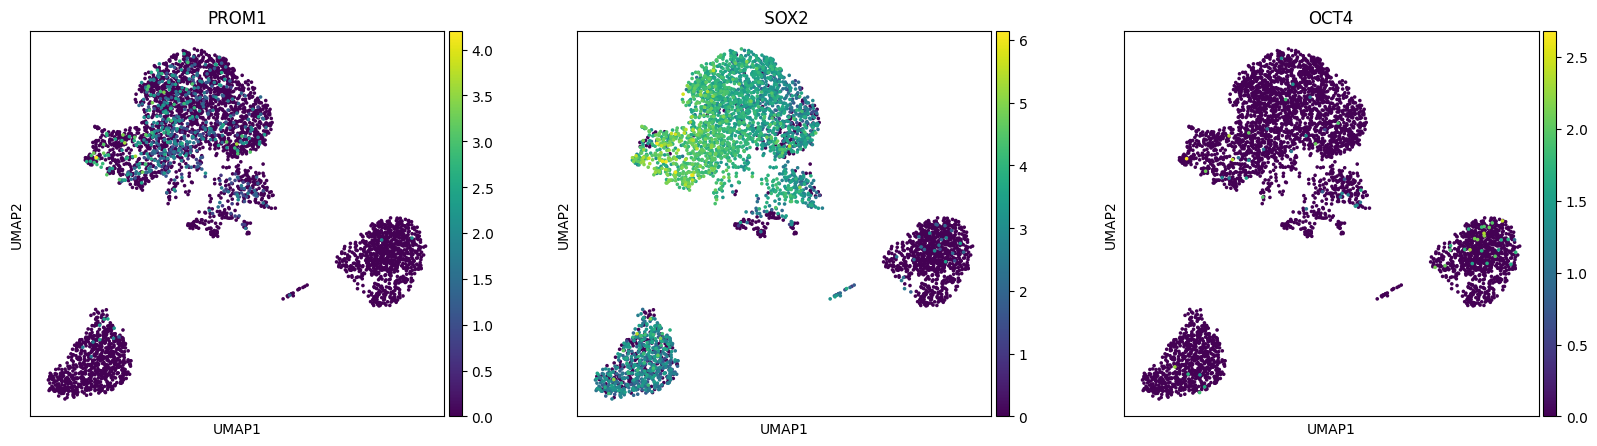

In [78]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (20, 5))

#各グラフを横に配置
sc.pl.umap (adata_fil, color = 'PROM1', title = "PROM1", ax = axes[0], show = False)
sc.pl.umap (adata_fil, color = 'SOX2', title = " SOX2", ax = axes[1], show = False)
sc.pl.umap (adata_fil, color = 'POU5F1', title = "OCT4", ax = axes[2], show = False)

plt.show()


KeyError: 'Could not find key VEGF in .var_names or .obs.columns.'

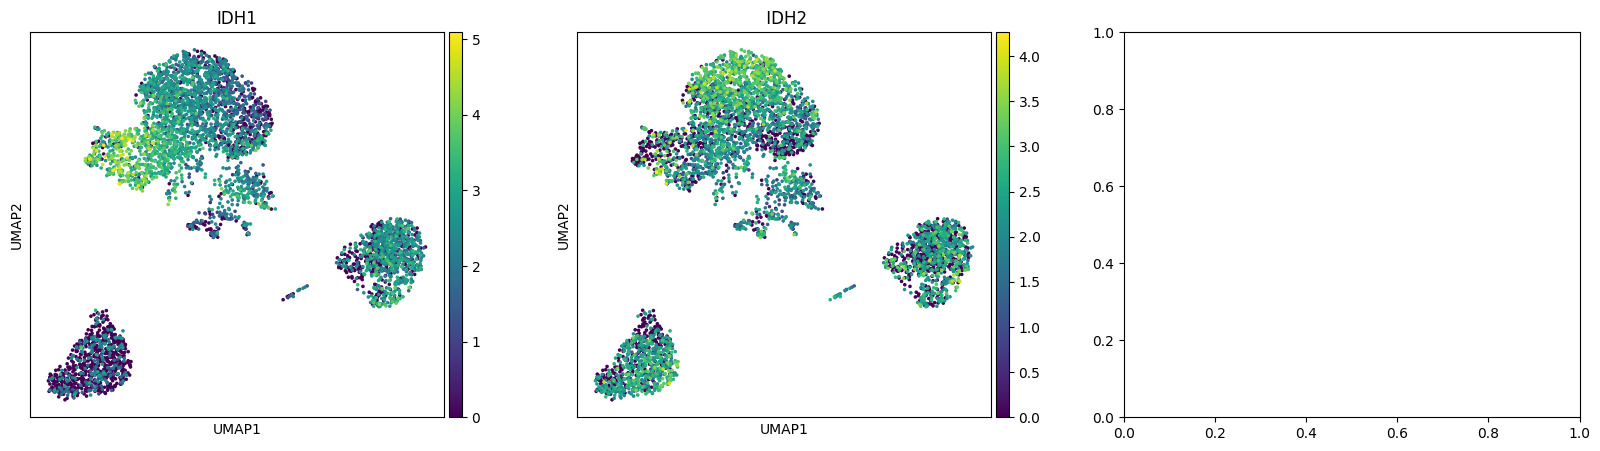

In [83]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (20, 5))

#各グラフを横に配置
sc.pl.umap (adata_fil, color = 'IDH1', title = "IDH1", ax = axes[0], show = False)
sc.pl.umap (adata_fil, color = 'IDH2', title = " IDH2", ax = axes[1], show = False)
sc.pl.umap (adata_fil, color = 'VEGF', title = "VEGF", ax = axes[2], show = False)

plt.show()


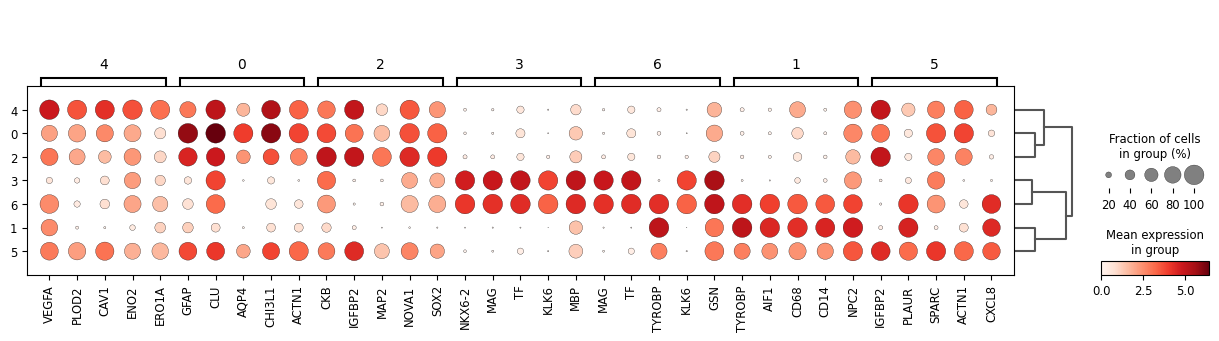

In [60]:
sc.pl.rank_genes_groups_dotplot(adata_fil, n_genes=5)

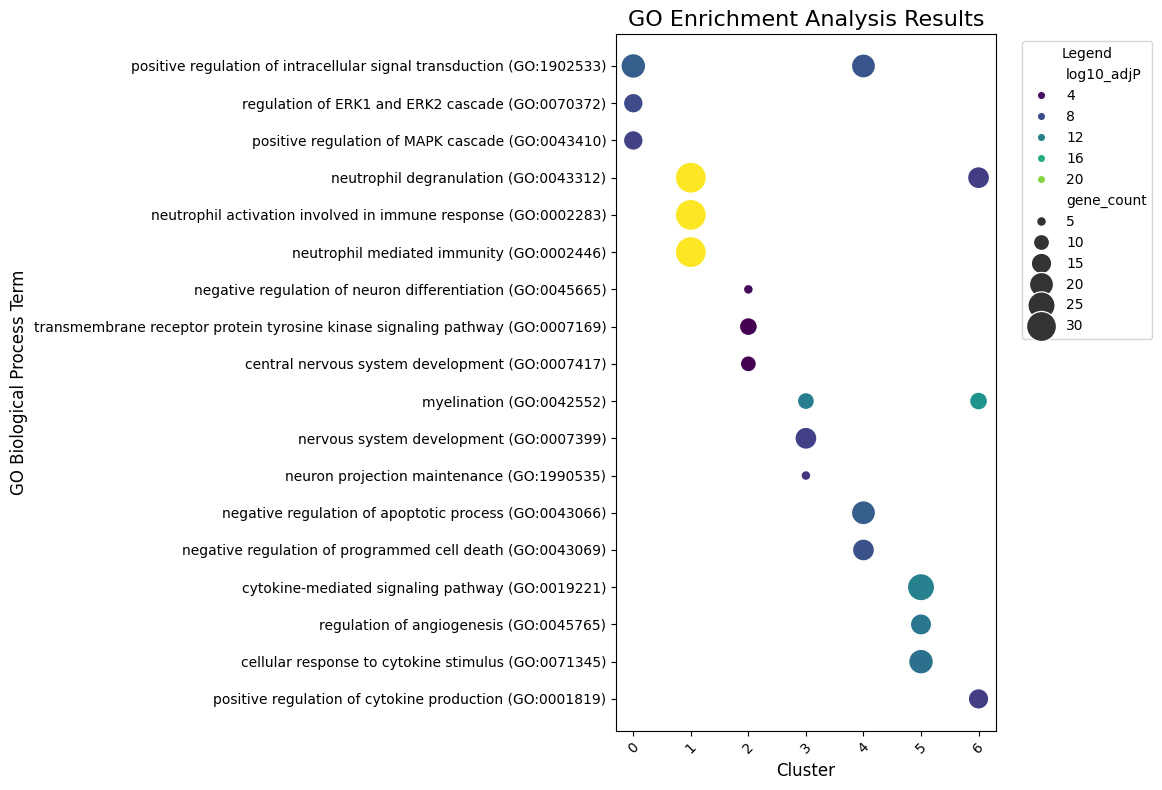

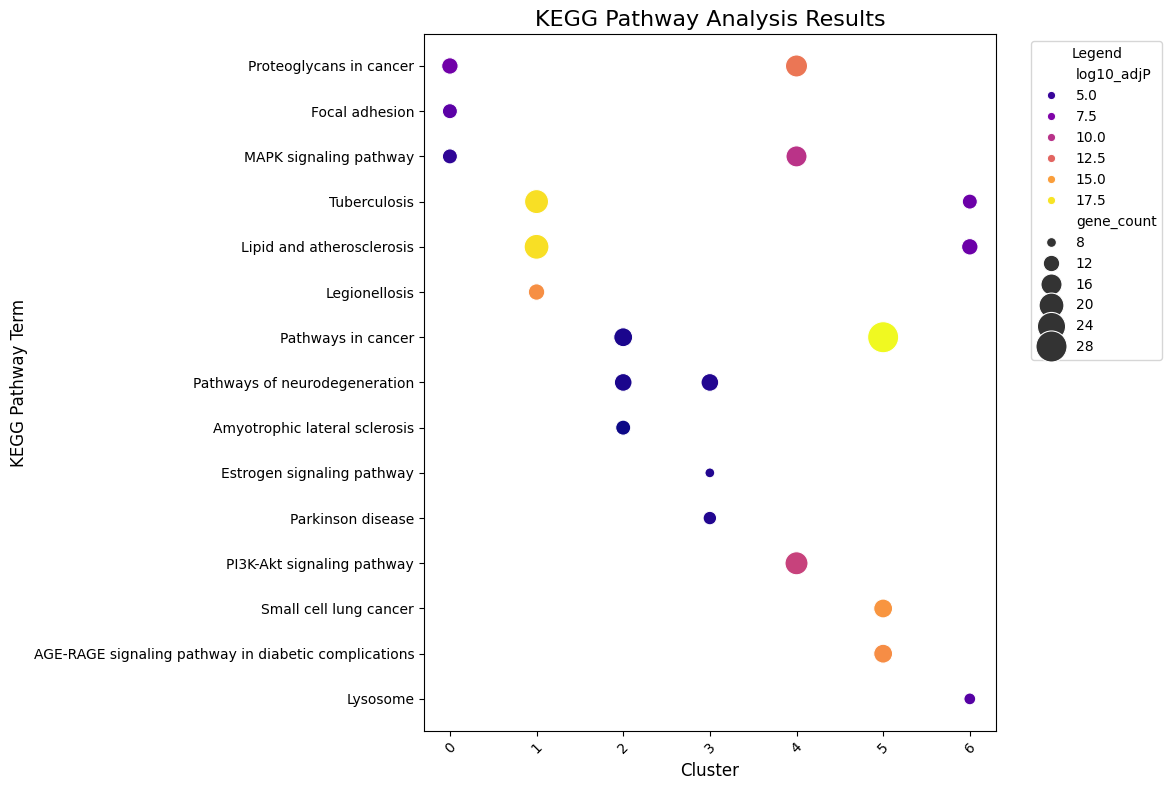

In [80]:
##GO解析結果をまとめるコード
#コピペ

# --- 設定項目 ---
# 存在するクラスターのリスト (ご自身のデータに合わせて変更してください)
# 例えばクラスターが0から6まである場合
CLUSTER_IDS = [str(i) for i in range(7)]

# 各クラスターから上位何位までのTermを抽出するか
N_TOP_TERMS = 3

# --- 1. GO解析結果の集約と可視化 ---

# 全クラスターの結果を格納するための空のDataFrame
all_go_results = []

for cluster_id in CLUSTER_IDS:
    filepath = f"go_enrichment_{cluster_id}/{cluster_id}_go_results.csv"
    if os.path.exists(filepath):
        # CSVファイルを読み込み
        df = pd.read_csv(filepath)
        # 上位N件を抽出
        top_terms = df.head(N_TOP_TERMS).copy()
        # どのクラスターの結果か分かるように列を追加
        top_terms['cluster'] = cluster_id
        all_go_results.append(top_terms)

# リスト内のDataFrameを一つに結合
if all_go_results:
    combined_go_df = pd.concat(all_go_results, ignore_index=True)

    # --- プロット用のデータ前処理 ---
    # 1. P値の対数変換 (-log10) を計算（値が大きいほど有意になる）
    combined_go_df['log10_adjP'] = -np.log10(combined_go_df['Adjusted P-value'])
    # 2. Overlap列から遺伝子数を抽出 (例: "21/546" -> 21)
    combined_go_df['gene_count'] = combined_go_df['Overlap'].apply(lambda x: int(x.split('/')[0]))

    # --- GO解析のドットプロットを描画 ---
    plt.figure(figsize=(12, 8)) # 図のサイズを調整
    sns.scatterplot(
        data=combined_go_df,
        x='cluster',
        y='Term',
        size='gene_count',      # ドットのサイズを遺伝子数に
        hue='log10_adjP',       # ドットの色をP値の対数に
        palette='viridis',      # カラーパレット
        sizes=(50, 500)         # ドットサイズの最小・最大値
    )
    plt.title('GO Enrichment Analysis Results', fontsize=16)
    plt.xlabel('Cluster', fontsize=12)
    plt.ylabel('GO Biological Process Term', fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Legend')
    plt.tight_layout() # レイアウトを自動調整
    plt.show()

# --- 2. KEGGパスウェイ解析結果の集約と可視化 (GOとほぼ同じ流れ) ---

all_kegg_results = []
for cluster_id in CLUSTER_IDS:
    filepath = f"kegg_enrichment_{cluster_id}/{cluster_id}_kegg_results.csv"
    if os.path.exists(filepath):
        df = pd.read_csv(filepath)
        top_terms = df.head(N_TOP_TERMS).copy()
        top_terms['cluster'] = cluster_id
        all_kegg_results.append(top_terms)

if all_kegg_results:
    combined_kegg_df = pd.concat(all_kegg_results, ignore_index=True)
    combined_kegg_df['log10_adjP'] = -np.log10(combined_kegg_df['Adjusted P-value'])
    combined_kegg_df['gene_count'] = combined_kegg_df['Overlap'].apply(lambda x: int(x.split('/')[0]))

    plt.figure(figsize=(12, 8))
    sns.scatterplot(
        data=combined_kegg_df,
        x='cluster',
        y='Term',
        size='gene_count',
        hue='log10_adjP',
        palette='plasma',
        sizes=(50, 500)
    )
    plt.title('KEGG Pathway Analysis Results', fontsize=16)
    plt.xlabel('Cluster', fontsize=12)
    plt.ylabel('KEGG Pathway Term', fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Legend')
    plt.tight_layout()
    plt.show()